In [4]:
import os

if "src" not in os.listdir():
    os.chdir("../")

In [5]:
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import ResponseSchema, StructuredOutputParser

tqdm.pandas()

docker run --runtime nvidia --gpus all \
    -v ~/.cache/huggingface:/root/.cache/huggingface \
    -p 8000:8000 \
    --ipc=host \
    vllm/vllm-openai:latest \
    --model Qwen/Qwen2.5-7B-Instruct --enable-prefix-caching

docker run --runtime nvidia --gpus all --rm \
    -v ~/.cache/huggingface:/root/.cache/huggingface \
    -p 8000:8000 \
    --ipc=host \
    vllm/vllm-openai:latest \
    --model IlyaGusev/saiga_llama3_8b --enable-prefix-caching

docker run --runtime nvidia --gpus all \
    -v ./models:/root/.cache/huggingface \
    -p 8000:8000 \
    --ipc=host \
    vllm/vllm-openai:latest \
    --model unsloth/qwen2.5-7b-instruct-bnb-4bit --enable-prefix-caching --download-dir /root/.cache/huggingface/qwen/vllm


docker run --runtime nvidia --gpus all --rm    \
    -v  ~/.cache/huggingface:/root/.cache/huggingface  \
    -v ./models:/root/models/ \
    -p 8000:8000   \
    --ipc=host   \
    vllm/vllm-openai:latest --model unsloth/Qwen2.5-7B-Instruct --enable-prefix-caching --enable-lora --lora-modules law-lora=/root/models/qwen/lora/

## Общий код для генерации и оценки ответов

In [6]:
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"
lora_name = "law-lora"

client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)

In [8]:
models = client.models.list()
model = models.data[0].id
model

'unsloth/Qwen2.5-7B-Instruct'

In [9]:
models.data

[Model(id='unsloth/Qwen2.5-7B-Instruct', created=1736846939, object='model', owned_by='vllm', root='unsloth/Qwen2.5-7B-Instruct', parent=None, max_model_len=32768, permission=[{'id': 'modelperm-87afededb6ce49fbb3e2e434672839c1', 'object': 'model_permission', 'created': 1736846939, 'allow_create_engine': False, 'allow_sampling': True, 'allow_logprobs': True, 'allow_search_indices': False, 'allow_view': True, 'allow_fine_tuning': False, 'organization': '*', 'group': None, 'is_blocking': False}]),
 Model(id='law-lora', created=1736846939, object='model', owned_by='vllm', root='/root/models/qwen/lora/', parent='unsloth/Qwen2.5-7B-Instruct', max_model_len=None, permission=[{'id': 'modelperm-b5ba3686891d41da89af032e5a2d7935', 'object': 'model_permission', 'created': 1736846939, 'allow_create_engine': False, 'allow_sampling': True, 'allow_logprobs': True, 'allow_search_indices': False, 'allow_view': True, 'allow_fine_tuning': False, 'organization': '*', 'group': None, 'is_blocking': False}])]

In [10]:
chat_completion = client.chat.completions.create(
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Who won the world series in 2020?"},
        {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
        {"role": "user", "content": "Where was it played?"},
    ],
    model="law-lora",
)

print("Chat completion results:")
print(chat_completion.choices[0].message.content)

Chat completion results:
The 2020 World Series was played in a best-of-seven format at three neutral sites due to the ongoing COVID-19 pandemic. The games were played at Globe Life Field in Arlington, Texas; Truist Park in Atlanta, Georgia; and Dodger Stadium in Los Angeles, California.


In [11]:
client.chat.completions.create

<bound method Completions.create of <openai.resources.chat.completions.Completions object at 0x73385cf3b910>>

In [12]:
df = pd.read_pickle("./data/interim/evalutions/benchmarks/100_prompt.pkl")

In [13]:
df.columns

Index(['index', 'prompt', 'prompt_not_answer', 'answer', 'question',
       'prompt_list', 'prompt_list_not_answer', 'prompt_context',
       'prompt_context_not_answer', 'context', 'prompt_list_context',
       'prompt_list_context_not_answer'],
      dtype='object')

In [14]:
df["prompt_context_not_answer"][0]

'<|im_start|>system\nТы юрист. Ты консультируешь людей по разным проблемам, внимательно прочитай, что тебе пишут, ответь на поставленные вопросы и дай консультацию. Ответ пиши только на РУССКОМ языке!<|im_end|>\n<|im_start|>user\nЧто делать если не берут а Армию? Я очень хочу служить России.<|im_end|>\n<|im_start|>system\nПеред тем как дать консультацию изучи вопросы других людей и ответы на них других юристов:\n\n    Вопрос гражданина:\n    Что делать если меня не берут в армию.\n    Ответ юриста:\n    Наслаждаться жизнью.А если вам так туда хочется-обжалуйте решение призывной комиссии.\n    \n    Вопрос гражданина:\n    Я хочу в Армию но меня не берут. По причине не известно. Что делать. Очень хочу служить.\n    Ответ юриста:\n    Вам не сказали результаты комиссии?\n    \n    Вопрос гражданина:\n    Хочу в армию а не берут что делать?\n    Ответ юриста:\n    Если Вам уже 18 лет(до 27 лет) и нет оснований для отсрочки(болезнь, учеба,семейное положение и т.д) вас обязаны призвать в ар

In [15]:
stream = False
completion = client.completions.create(
    model=model, prompt=df["prompt_context_not_answer"][7], max_tokens=1000, seed=0
)

print(completion.choices[0].text)

Для того чтобы ответить на ваш вопрос, необходимо понять несколько ключевых моментов:

1. **Основное правило**: В соответствии с Жилищным кодексом РФ, земельный участок, на котором расположен многоквартирный дом, является общим имуществом для всех собственников помещений в этом доме. Это означает, что все доли в праве собственности на этот участок принадлежат всем собственникам квартир пропорционально площади их помещений.

2. **Распределение долей**: Если ваш дом является пятиквартирным и все квартиры находятся в долевой собственности, все собственники этих квартир имеют равные доли в праве общей собственности на земельный участок. Размер доли у каждого собственника зависит от общей площади его квартиры. То есть, если площади ваших квартир разные, размеры долей в праве общей собственности на земельный участок также будут разными, но общая площадь участка будет распределена пропорционально общей площади всех квартир.

3. **Регистрация**: Земельный участок должен登记并审核以下文档：
   - 房产证原件及复印

In [16]:
stream = False
completion = client.completions.create(
    model="law-lora", prompt=df["prompt_context_not_answer"][7], max_tokens=1000, seed=0
)

print(completion.choices[0].text)

Дело в том, что земельный участок, который расположен под многоквартирным домом, является общим имуществом собственников помещений, находящихся в таком доме, в пределах Swan права, определенных долями (ст. 4, ч. 1 ст. 36 ЖК РФ). Размер доли каждого собственника определяется его долями в праве собственности или владения на соответствующие помещения в том доме. Влияет это на долю в праве на общее имущество, в т.ч. на земельный участок. Таким образом, земельный участок приватизируется в долевую собственность всех собственников квартир, расположенных на этом участке, на всей его площади в пропорции к квадратным метрам принадлежащих им квадратных метров в общей сумме площади квартир, расположенных на участке.

Таким образом, в случае долях не будет никакого соотношения между долей в праве на квартиру и долей в праве на земельный участок.


In [17]:
chat_completion = client.chat.completions.create(
    messages=df["prompt_list_context_not_answer"][5], model=model, seed=1, max_tokens=1000
)

print("Chat completion results:")
print(chat_completion.choices[0].message.content)

Chat completion results:
Для того чтобы вернуть деньги за предоплату, вы можете использовать следующую статью Закона о защите прав потребителей:

### Статья 23.1. Отказ исполнителя (дистанционного продавца) от исполнения договора купли-продажи, предоставления услуги или выполнения работ

Если срок исполнения договора истек и мебель не была предоставленна, вы можете требовать возврата предоплаты.

### Шаги для возврата денег:

1. **Составьте претензию**: В претензии укажите:
   - ФИО и контактные данные продавца.
   - Данные договора купли-продажи.
   - Сумму предоплаты.
   - Дату и срок изготовления мебели.
   - Требование о возврате предоплаты.
   - Дату отдачи претензии продавцу.
   - Срок рассмотрения претензии (10 дней с момента получения).

2. **Отправьте претензию**: Сделайте копию претензии и отправьте ее продавцу по почте с уведомлением об отдаче.

3. **Если возврата денег не будет**: Если в течении 10 дней после получения претензии деньги не были возвращены, вы можете подать и

In [46]:
# Для ответа использую json следующего вида:
# {{
# "russian_language": Используеться только русский язык или нет. Если используеться китайский, то всегда указывай "нет",
# "matching_target_answer": Соотвествие эталонному ответу. Учитывай, что ответ должен быть коротким и понятным.
# "score": Финальная оценка соотвествия ответ ассистента эталонному ответу от 0 до 10. Если ответ ассистента длиный снижай 2 балла.
# }}

JUDGE_PROMPT = """
**Инструкция для проверки ответов**
Ты профессиональный юрист, который оценивает работу ассистентов в сфере юридических консультаций.
Тебе будет передан для оценки вопрос пользователя, ответ асситента на вопрос пользователя и эталонный ответ. 
Твоя задача оценить ответ асситента и его соотвествие эталонному ответу и выставить финальную оценку от 0 до 5, где 0 самая плохая оценка, а 5 лучшая.
За успешно выполненную работу тебе заплатят 10$.

**Критерии анализа ответа**:
1. Учитывай длину ответа, если ответ сильно больше эталонного снижай оценку.
2. Учитывай насколько ответ дан по существу. Если ассистент не отвечает на вопрос, то снижай оценку.
3. Если в ответе использовался не русский язык, то снижай оценку.
4. Учитывай фактическую правильность ответа, если ответ ассистента по сути противоречит эталонному ответу, то ставь не больше 2х баллов

**Формат ответа**
{format_instructions}

Пример формата ответа:
```json 
{{
	"russian_language": "да",
	"matching_target_answer": "Ответ не соотвествует эталонному ответу",
    "correctness": "нет",
	"score": 1
}}
```

```json 
{{
	"russian_language": "да",
	"matching_target_answer": "Ответ соотвествует эталонному ответу, но содержит лишнюю информацию и слишком длинный",
    "correctness": "да",
	"score": 4
}}
```
При написании ответа не пиши ничего, что не может быть распознано как json-файл
Пример, который не будет распознан, как json:
```json 
{{
	"russian_language": "да", // какой-то комментарий
	"matching_target_answer": "Ответ соотвествует эталонному ответу, но содержит лишнюю информацию и слишком длинный", // какой-то комментарий
    "correctness": "да", // какой-то комментарий
	"score": 4 // какой-то комментарий
}}
```


**Данные для анализа**:
Вопрос: {question}

Ответ ассистента: {answer}

Эталонный ответ: {target}

**Твой ответ**
Теперь дай оценку ответа асситента:
"""

In [41]:
russian_language = ResponseSchema(
    name="russian_language",
    description=" Используеться только русский язык или нет. Если используеться китайский, то всегда указывай 'нет'",
)

matching_target_answer = ResponseSchema(
    name="matching_target_answer",
    description="Соотвествие эталонному ответу. Учитывай, что ответ должен быть коротким и понятным.",
)

correctness = ResponseSchema(
    name="correctness",
    description=(
        "Здесь укажи корректная ли информация изложенная в ответе, тоесть противоречит ли информация "
        "в ответе ассистента информации в эталонном ответе. "
        "Если информация не корректная, то пиши 'нет', если корректная, то 'да'"
    ),
)

score = ResponseSchema(
    name="score",
    description="Финальная оценка ответа ассистента от 0 до 5.",
    type="int",
)


response_schemas = [russian_language, matching_target_answer, correctness, score]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"russian_language": string  //  Используеться только русский язык или нет. Если используеться китайский, то всегда указывай 'нет'
	"matching_target_answer": string  // Соотвествие эталонному ответу. Учитывай, что ответ должен быть коротким и понятным.
	"correctness": string  // Здесь укажи корректная ли информация изложенная в ответе, тоесть противоречит ли информация в ответе ассистента информации в эталонном ответе. Если информация не корректная, то пиши 'нет', если корректная, то 'да'
	"score": int  // Финальная оценка ответа ассистента от 0 до 5.
}
```


In [20]:
prompt_judge = PromptTemplate(
    input_variables=["question", "answer", "target"], template=JUDGE_PROMPT
)
print(
    prompt_judge.invoke(
        input={
            "format_instructions": format_instructions,
            "question": "owl",
            "answer": "owl1",
            "target": "owl2",
        }
    ).text
)


**Инструкция для проверки ответов**
Ты профессиональный юрист, который оценивает работу ассистентов в сфере юридических консультаций.
Тебе будет передан для оценки вопрос пользователя, ответ асситента на вопрос пользователя и эталонный ответ. 
Твоя задача оценить ответ асситента и его соотвествие эталонному ответу и выставить финальную оценку от 0 до 5, где 0 самая плохая оценка, а 5 лучшая.
За успешно выполненную работу тебе заплатят 10$.

**Критерии анализа ответа**:
1. Учитывай длину ответа, если ответ сильно больше эталонного снижай оценку.
2. Учитывай насколько ответ дан по существу. Если ассистент не отвечает на вопрос, то снижай оценку.
3. Если в ответе использовался не русский язык, то снижай оценку.
4. Учитывай фактическую правильность ответа, если ответ ассистента по сути противоречит эталонному ответу, то ставь не больше 2х баллов

**Формат ответа**
The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" a

In [21]:
df["prompt_list_context_not_answer"][4]

[{'role': 'system',
  'content': 'Ты юрист. Ты консультируешь людей по разным проблемам, внимательно прочитай, что тебе пишут, ответь на поставленные вопросы и дай консультацию. Ответ пиши только на РУССКОМ языке!'},
 {'role': 'user',
  'content': 'Может ли ребёнок с российским гражданством быть переведён в школу КЗ? По национальности казах. Без внж, внж в процессе.'},
 {'role': 'system',
  'content': 'Перед тем как дать консультацию изучи вопросы других людей и ответы на них других юристов:\n\n    Вопрос гражданина:\n    Может ли ребёнок с Казахстанским гражданством пойтив в школу в России.\n    Ответ юриста:\n    Проживая по месту жительства одного из родителей, ребёнок имеет право идти в школу с любым гражданством, лишь бы хотел учиться.\n    \n    Вопрос гражданина:\n    Здравствуйте! Я хотела узнать, могу ли я отдать своего ребенка в Российскую школу  имея Казахстанское гражданство?\n    Ответ юриста:\n    Имеете право по месту регистрации в РФ. В случае отказа обращайтесь с жалоб

In [22]:
index = 16
chat_completion = client.chat.completions.create(
    messages=df["prompt_list_context_not_answer"][index], model=model, seed=1, max_tokens=1000
)

answer = chat_completion.choices[0].message.content

promt_final = prompt_judge.invoke(
    {
        "format_instructions": format_instructions,
        "question": df["question"][index],
        "answer": answer,
        "target": df["answer"][index],
    }
).text

completion = client.chat.completions.create(
    messages=[{"role": "system", "content": promt_final}], model=model, seed=1, max_tokens=1000
)

evaluation = completion.choices[0].message.content
print(evaluation)
output_dict = output_parser.parse(evaluation)
output_dict

```json
{
	"russian_language": "да",
	"matching_target_answer": "Ответ содержит основную информацию из эталонного ответа, но не полностью соответствует его структуре и детализации.",
    "correctness": "да",
	"score": 3
}
```


{'russian_language': 'да',
 'matching_target_answer': 'Ответ содержит основную информацию из эталонного ответа, но не полностью соответствует его структуре и детализации.',
 'correctness': 'да',
 'score': 3}

In [23]:
promt_final

'\n**Инструкция для проверки ответов**\nТы профессиональный юрист, который оценивает работу ассистентов в сфере юридических консультаций.\nТебе будет передан для оценки вопрос пользователя, ответ асситента на вопрос пользователя и эталонный ответ. \nТвоя задача оценить ответ асситента и его соотвествие эталонному ответу и выставить финальную оценку от 0 до 5, где 0 самая плохая оценка, а 5 лучшая.\nЗа успешно выполненную работу тебе заплатят 10$.\n\n**Критерии анализа ответа**:\n1. Учитывай длину ответа, если ответ сильно больше эталонного снижай оценку.\n2. Учитывай насколько ответ дан по существу. Если ассистент не отвечает на вопрос, то снижай оценку.\n3. Если в ответе использовался не русский язык, то снижай оценку.\n4. Учитывай фактическую правильность ответа, если ответ ассистента по сути противоречит эталонному ответу, то ставь не больше 2х баллов\n\n**Формат ответа**\nThe output should be a markdown code snippet formatted in the following schema, including the leading and trail

In [24]:
evaluation

'```json\n{\n\t"russian_language": "да",\n\t"matching_target_answer": "Ответ содержит основную информацию из эталонного ответа, но не полностью соответствует его структуре и детализации.",\n    "correctness": "да",\n\t"score": 3\n}\n```'

In [25]:
df.head(1)

,index,prompt,prompt_not_answer,answer,question,prompt_list,prompt_list_not_answer,prompt_context,prompt_context_not_answer,context,prompt_list_context,prompt_list_context_not_answer
0,10959844,<|im_start|>system\nТы юрист. Ты консультируеш...,<|im_start|>system\nТы юрист. Ты консультируеш...,"Если военкомат отказал официально, обжалуйте е...",Что делать если не берут а Армию? Я очень хочу...,"[{'role': 'system', 'content': 'Ты юрист. Ты к...","[{'role': 'system', 'content': 'Ты юрист. Ты к...",<|im_start|>system\nТы юрист. Ты консультируеш...,<|im_start|>system\nТы юрист. Ты консультируеш...,Перед тем как дать консультацию изучи вопросы ...,"[{'role': 'system', 'content': 'Ты юрист. Ты к...","[{'role': 'system', 'content': 'Ты юрист. Ты к..."


### Генерация ответа

In [26]:
def generate_answer(df: pd.DataFrame, model):
    eval_list = []
    for index in tqdm(range(len(df))):
        prompt_list_not_answer = df["prompt_list_not_answer"][index]
        prompt_list_context_not_answer = df["prompt_list_context_not_answer"][index]
        target = df["answer"][index]
        question = df["question"][index]
        context = df["context"][index]

        chat_completion = client.chat.completions.create(
            messages=prompt_list_not_answer,
            model=model,
            seed=1,
            max_tokens=1000,
            stream=True,
        )
        chat_completion_context = client.chat.completions.create(
            messages=prompt_list_context_not_answer,
            model=model,
            seed=1,
            max_tokens=1000,
            stream=True,
        )

        answer = "".join([i.choices[0].delta.content for i in chat_completion])
        answer_context = "".join([i.choices[0].delta.content for i in chat_completion_context])

        eval_list.append(
            {
                "prompt_list_not_answer": prompt_list_not_answer,
                "prompt_list_context_not_answer": prompt_list_context_not_answer,
                "target": target,
                "question": question,
                "context": context,
                "answer": answer,
                "answer_context": answer_context,
            }
        )
    return eval_list

In [27]:
eval_list_base_model = generate_answer(df, model)
eval_list_lora = generate_answer(df, lora_name)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:15<00:00,  3.75s/it]


### Оценка ответа

In [50]:
def evalutions_answers(eval_list, model):
    for index in tqdm(range(len(eval_list))):
        answer = eval_list[index]["answer"]
        answer_context = eval_list[index]["answer_context"]
        target = eval_list[index]["target"]

        promt_eval = prompt_judge.invoke(
            {
                "format_instructions": format_instructions,
                "question": df["question"][index],
                "answer": answer,
                "target": target,
            }
        ).text
        promt_eval_context = prompt_judge.invoke(
            {
                "format_instructions": format_instructions,
                "question": df["question"][index],
                "answer": answer_context,
                "target": target,
            }
        ).text

        chat_completion = client.chat.completions.create(
            messages=[{"role": "system", "content": promt_eval}],
            model=model,
            seed=1,
            max_tokens=1000,
            stream=True,
        )
        chat_completion_context = client.chat.completions.create(
            messages=[{"role": "system", "content": promt_eval_context}],
            model=model,
            seed=1,
            max_tokens=1000,
            stream=True,
        )
        evalution = "".join([i.choices[0].delta.content for i in chat_completion])
        evalution_context = "".join([i.choices[0].delta.content for i in chat_completion_context])

        try:
            evalution = output_parser.parse(evalution)
        except Exception as e:
            chat_completion = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": promt_eval},
                    {"role": "assistant", "content": evalution},
                    {"role": "user", "content": "Ты вернул json, который не может быть распарщен! Перепиши его так, чтобы его можно было спарсить!"},
                ],
                model=model,
                seed=1,
                max_tokens=1000,
                stream=True,
            )
            evalution = "".join([i.choices[0].delta.content for i in chat_completion])
            evalution = output_parser.parse(evalution)

        try:
            evalution_context = output_parser.parse(evalution_context)
        except Exception as e:
            chat_completion_context = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": promt_eval},
                    {"role": "assistant", "content": evalution_context},
                    {"role": "user", "content": "Ты вернул json, который не может быть распарщен! Перепиши его так, чтобы его можно было спарсить!"},
                ],
                model=model,
                seed=1,
                max_tokens=1000,
                stream=True,
            )
            evalution_context = "".join([i.choices[0].delta.content for i in chat_completion_context])
            evalution_context = output_parser.parse(evalution_context)

        eval_list[index]["promt_eval"] = promt_eval
        eval_list[index]["promt_eval_context"] = promt_eval_context
        eval_list[index]["evalution"] = evalution
        eval_list[index]["evalution_context"] = evalution_context
        eval_list[index]["correctness"] = evalution["correctness"]
        eval_list[index]["correctness_context"] = evalution_context["correctness"]
        eval_list[index]["score"] = evalution["score"]
        eval_list[index]["score_context"] = evalution_context["score"]

In [51]:
models = client.models.list()
model = models.data[0].id
model

'IlyaGusev/saiga_llama3_8b'

In [52]:
evalutions_answers(eval_list_base_model, model)
evalutions_answers(eval_list_lora, model)

100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


In [64]:
df_evalution_base_model = pd.DataFrame(eval_list_base_model)
df_evalution_lora = pd.DataFrame(eval_list_lora)

(<Axes: >, <Axes: >)

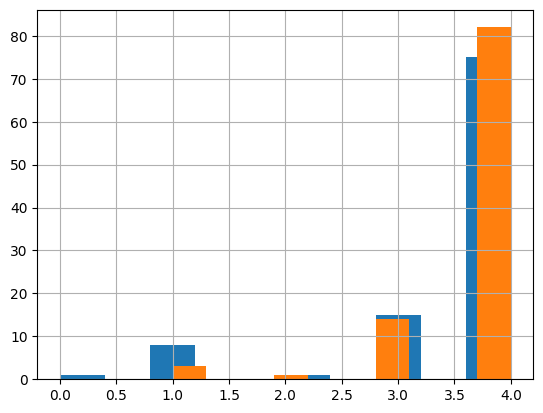

In [68]:
df_evalution_base_model["score"].hist(), df_evalution_base_model["score_context"].hist()

(<Axes: >, <Axes: >)

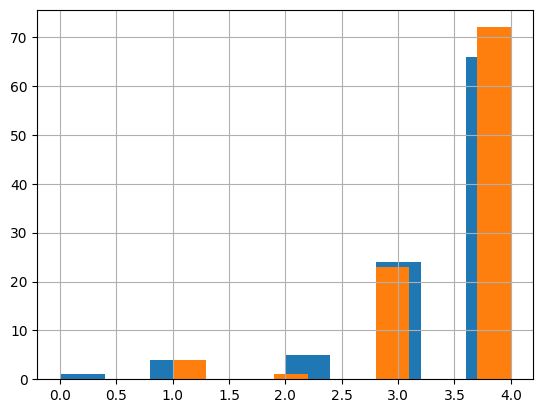

In [69]:
df_evalution_lora["score"].hist(), df_evalution_lora["score_context"].hist()

In [71]:
df_evalution_base_model["score_context"].describe(), df_evalution_lora["score_context"].describe()

(count    100.000000
 mean       3.750000
 std        0.625631
 min        1.000000
 25%        4.000000
 50%        4.000000
 75%        4.000000
 max        4.000000
 Name: score_context, dtype: float64,
 count    100.000000
 mean       3.630000
 std        0.705748
 min        1.000000
 25%        3.000000
 50%        4.000000
 75%        4.000000
 max        4.000000
 Name: score_context, dtype: float64)

In [76]:
def display_data(eval_list: list):
    for i in eval_list:
        print("QUESTION", i["question"])
        print()
        print("CONTEXT", i["context"])
        print()
        print("TARGET", i["target"])
        # print()
        # print("ANSWER", i["answer"])
        # print("EVALUTION", i["evalution"])
        print()
        print("ANSWER_CONTEXT", i["answer_context"])
        print("EVALUTION_CONTEXT", i["evalution_context"])
        print()
        print(
            "----------------------------------------------------------------------------------------"
        )

In [77]:
display_data(eval_list_base_model)

QUESTION Что делать если не берут а Армию? Я очень хочу служить России.

CONTEXT Перед тем как дать консультацию изучи вопросы других людей и ответы на них других юристов:

    Вопрос гражданина:
    Что делать если меня не берут в армию.
    Ответ юриста:
    Наслаждаться жизнью.А если вам так туда хочется-обжалуйте решение призывной комиссии.
    
    Вопрос гражданина:
    Я хочу в Армию но меня не берут. По причине не известно. Что делать. Очень хочу служить.
    Ответ юриста:
    Вам не сказали результаты комиссии?
    
    Вопрос гражданина:
    Хочу в армию а не берут что делать?
    Ответ юриста:
    Если Вам уже 18 лет(до 27 лет) и нет оснований для отсрочки(болезнь, учеба,семейное положение и т.д) вас обязаны призвать в армию.Сходите в военкомат,пройдите медицинскую комиссию и удачной службы!
    
    Вопрос гражданина:
    Я хочу в армию а меня не берут что делать?
    Ответ юриста:
    Я хочу в армию но меня не берут что делатьПопробовать захотеть что-то другое. Не всем же 

In [78]:
display_data(eval_list_lora)

QUESTION Что делать если не берут а Армию? Я очень хочу служить России.

CONTEXT Перед тем как дать консультацию изучи вопросы других людей и ответы на них других юристов:

    Вопрос гражданина:
    Что делать если меня не берут в армию.
    Ответ юриста:
    Наслаждаться жизнью.А если вам так туда хочется-обжалуйте решение призывной комиссии.
    
    Вопрос гражданина:
    Я хочу в Армию но меня не берут. По причине не известно. Что делать. Очень хочу служить.
    Ответ юриста:
    Вам не сказали результаты комиссии?
    
    Вопрос гражданина:
    Хочу в армию а не берут что делать?
    Ответ юриста:
    Если Вам уже 18 лет(до 27 лет) и нет оснований для отсрочки(болезнь, учеба,семейное положение и т.д) вас обязаны призвать в армию.Сходите в военкомат,пройдите медицинскую комиссию и удачной службы!
    
    Вопрос гражданина:
    Я хочу в армию а меня не берут что делать?
    Ответ юриста:
    Я хочу в армию но меня не берут что делатьПопробовать захотеть что-то другое. Не всем же 

In [38]:
df_evalute.to_pickle("data/interim/evalutions/result/100_prompt_Qwen2.5-7B-Instruct.pkl")

In [5]:
df_evalute = pd.read_pickle("data/interim/evalutions/result/100_prompt_Qwen2.5-7B-Instruct.pkl")

(<Axes: >, <Axes: >)

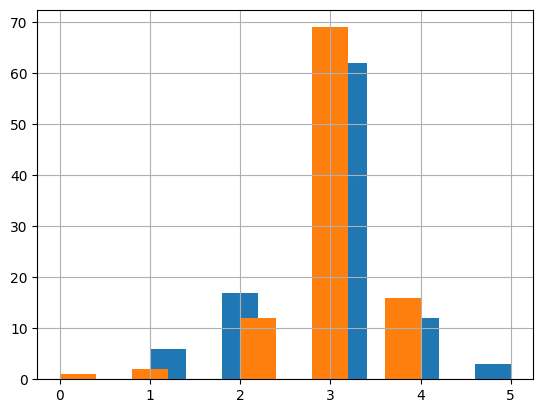

In [7]:
df_evalute["score"].hist(), df_evalute["score_context"].hist()

In [21]:
df_0 = df_evalute[df_evalute["score_context"] == 3]

In [22]:
display_data(df_0.to_dict("records"))

QUESTION Может ли ребёнок с российским гражданством быть переведён в школу КЗ? По национальности казах. Без внж, внж в процессе.

CONTEXT Перед тем как дать консультацию изучи вопросы других людей и ответы на них других юристов:

    Вопрос гражданина:
    Может ли ребёнок с Казахстанским гражданством пойтив в школу в России.
    Ответ юриста:
    Проживая по месту жительства одного из родителей, ребёнок имеет право идти в школу с любым гражданством, лишь бы хотел учиться.
    
    Вопрос гражданина:
    Здравствуйте! Я хотела узнать, могу ли я отдать своего ребенка в Российскую школу  имея Казахстанское гражданство?
    Ответ юриста:
    Имеете право по месту регистрации в РФ. В случае отказа обращайтесь с жалобой в управление образования, если и там получите отказ, - обращайтесь с жалобой в прокуратуру по месту регистрации в РФ. Пункт 8 ст 98 Договора о Евразийском экономическом союзе" (Подписан в г. Астане 29.05.2014) (ред. от 08.05.2015) (с изм. и доп., вступ. В силу с 12.08.2017).

In [24]:
from unsloth import FastLanguageModel

max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
dtype = None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True  # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="./models/qwen/vllm",  # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)
FastLanguageModel.for_inference(model)  # Enable native 2x faster inference

==((====))==  Unsloth 2025.1.5: Fast Qwen2 patching. Transformers: 4.47.1.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.542 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584, padding_idx=151665)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((